# Подготовка модели распознавания рукописных букв и цифр

## Библиотеки

In [1]:
import os
import torch
import torchvision
from torchvision.datasets import EMNIST
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

## Просмотр данных и создание словаря соответствий

сразу при загрузке повернем и отразим данные

Функция: torchvision.transforms.functional.hflip(img)

    Параметры:
        img: Изображение, которое нужно отразить. Это может быть объект типа PIL Image или тензор. Если это тензор, он должен быть в формате [...,H,W][...,H,W], где ...... может иметь произвольное количество ведущих размерностей.
    Возвращает:
        Горизонтально отраженное изображение в том же формате, что и входное изображение (либо PIL Image, либо тензор).


In [2]:
dataset = EMNIST('data/', 'balanced', download=False, 
                transform=torchvision.transforms.Compose([ # поворачиваем и отражаем изображения
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    torchvision.transforms.ToTensor()
                ]))
train_data = EMNIST('data/', 'balanced', train=True, download=True,
                transform=torchvision.transforms.Compose([ # поворачиваем и отражаем изображения
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    torchvision.transforms.ToTensor()
                ]) )
test_data = EMNIST('data/', 'balanced', train=False,
                transform=torchvision.transforms.Compose([ # поворачиваем и отражаем изображения
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    torchvision.transforms.ToTensor()
                ]) )

# Проверка размера загруженных данных
print(f"Размер dataset: {len(dataset)}")
print(f"Размер обучающего набора: {len(train_data)}")
print(f"Размер тестового набора: {len(test_data)}")

Размер dataset: 112800
Размер обучающего набора: 112800
Размер тестового набора: 18800


Параметры загрузки

    root: Путь к директории, в которую будут загружены данные. Если данные уже загружены, они будут загружены из этой директории.
    split: Определяет, какую часть набора данных загружать. Возможные значения:
        "byclass": Загружает данные по классам.
        "bymerge": Объединяет классы.
        "balanced": Сбалансированный набор.
        "letters": Буквы.
        "digits": Цифры.
        "mnist": Стандартный MNIST.
    train: Если True, загружается обучающий набор; если False, тестовый набор.
    download: Если True, данные будут загружены из интернета, если они еще не существуют в указанной директории.

In [3]:
# метки train
train_data.targets

tensor([45, 36, 43,  ..., 23, 31,  8])

In [4]:
# Извлечение меток
train_labels = [label for _, label in train_data]
test_labels = [label for _, label in test_data]

# Проверка первых 10 меток
print("Первые 10 меток обучающего набора:", train_labels[:10])
print("Первые 10 меток тестового набора:", test_labels[:10])

Первые 10 меток обучающего набора: [45, 36, 43, 15, 4, 42, 26, 32, 20, 1]
Первые 10 меток тестового набора: [41, 39, 9, 26, 44, 33, 14, 11, 3, 12]


In [5]:
# получение маппинга
with open('data/EMNIST/raw/emnist-balanced-mapping.txt', 'r') as f:
    mapping = f.readlines()

mapping

['0 48\n',
 '1 49\n',
 '2 50\n',
 '3 51\n',
 '4 52\n',
 '5 53\n',
 '6 54\n',
 '7 55\n',
 '8 56\n',
 '9 57\n',
 '10 65\n',
 '11 66\n',
 '12 67\n',
 '13 68\n',
 '14 69\n',
 '15 70\n',
 '16 71\n',
 '17 72\n',
 '18 73\n',
 '19 74\n',
 '20 75\n',
 '21 76\n',
 '22 77\n',
 '23 78\n',
 '24 79\n',
 '25 80\n',
 '26 81\n',
 '27 82\n',
 '28 83\n',
 '29 84\n',
 '30 85\n',
 '31 86\n',
 '32 87\n',
 '33 88\n',
 '34 89\n',
 '35 90\n',
 '36 97\n',
 '37 98\n',
 '38 100\n',
 '39 101\n',
 '40 102\n',
 '41 103\n',
 '42 104\n',
 '43 110\n',
 '44 113\n',
 '45 114\n',
 '46 116\n']

In [6]:
# Создаем словарь соответствий
label_dict = {}
for entry in mapping:
    label, ascii_code = map(int, entry.split())
    label_dict[label] = chr(ascii_code)

In [7]:
# Подсчитываем количество тренировочных семплов для каждого лейбла
label_counts = np.bincount(train_data.targets)

In [8]:
# Выводим символы и количество семплов
print("Количество тренировочных семплов для каждого символа:")
for label, count in enumerate(label_counts):
    if count > 0:  # Печатаем только те лейблы, которые встречаются в выборке
        symbol = label_dict.get(label, '?')  # Получаем символ
        print(f'Символ: {symbol}, Лейбл: {label}, Количество: {count}')

Количество тренировочных семплов для каждого символа:
Символ: 0, Лейбл: 0, Количество: 2400
Символ: 1, Лейбл: 1, Количество: 2400
Символ: 2, Лейбл: 2, Количество: 2400
Символ: 3, Лейбл: 3, Количество: 2400
Символ: 4, Лейбл: 4, Количество: 2400
Символ: 5, Лейбл: 5, Количество: 2400
Символ: 6, Лейбл: 6, Количество: 2400
Символ: 7, Лейбл: 7, Количество: 2400
Символ: 8, Лейбл: 8, Количество: 2400
Символ: 9, Лейбл: 9, Количество: 2400
Символ: A, Лейбл: 10, Количество: 2400
Символ: B, Лейбл: 11, Количество: 2400
Символ: C, Лейбл: 12, Количество: 2400
Символ: D, Лейбл: 13, Количество: 2400
Символ: E, Лейбл: 14, Количество: 2400
Символ: F, Лейбл: 15, Количество: 2400
Символ: G, Лейбл: 16, Количество: 2400
Символ: H, Лейбл: 17, Количество: 2400
Символ: I, Лейбл: 18, Количество: 2400
Символ: J, Лейбл: 19, Количество: 2400
Символ: K, Лейбл: 20, Количество: 2400
Символ: L, Лейбл: 21, Количество: 2400
Символ: M, Лейбл: 22, Количество: 2400
Символ: N, Лейбл: 23, Количество: 2400
Символ: O, Лейбл: 24

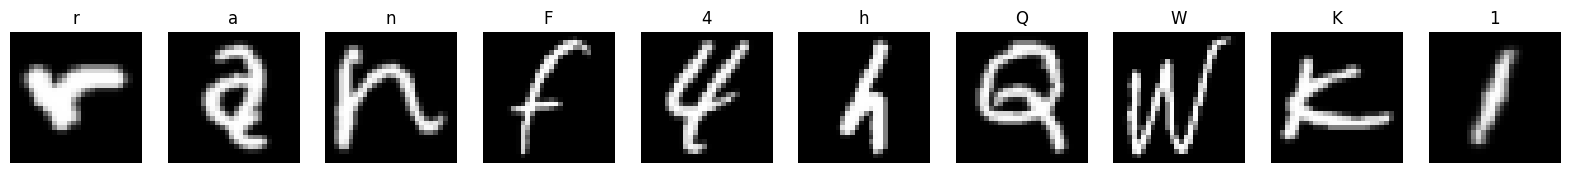

In [9]:
# Отображение 10 изображений и соответствующих меток
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    image, label = train_data[i]
    
    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.numpy()  # Прямое преобразование в NumPy массив
    
    # Убираем размерность канала (если она есть)
    if image_np.shape[0] == 1:  # Если канал один (черно-белое изображение)
        image_np = image_np.squeeze(0)  # Убираем размерность канала
    
    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')
    axs[i].set_title(label_dict[label])  # Используем словарь для отображения метки
    axs[i].axis('off')

plt.show()

## Загрузка, отражение и поворот, трансформация, нормализация данных

In [10]:
# Обертка трансформации и нормализации
transform = Compose([
    ToTensor(),
    Normalize([0.5], [0.5])
])

In [11]:
# Загрузка обучающего набора данных с трансформациями
train_data = EMNIST('data/', 'balanced', train=True, download=True,
                transform=torchvision.transforms.Compose([ # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

In [12]:
# Загрузка тестового набора данных с трансформациями
test_data = EMNIST('data/', 'balanced', train=False,
                transform=torchvision.transforms.Compose([ # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

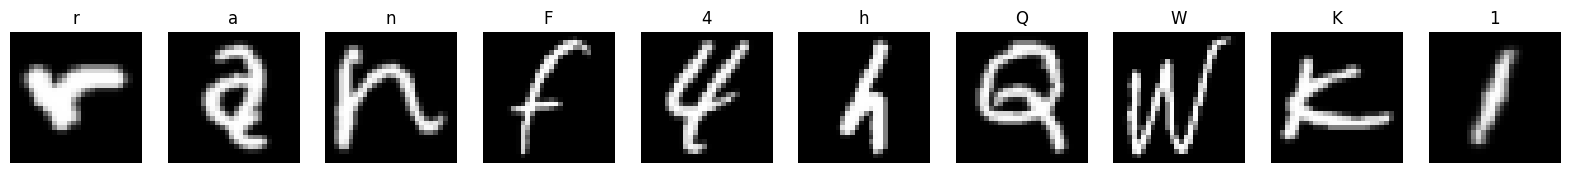

In [13]:
# Проверяем корректгость изображений
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    image, label = train_data[i]
    
    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.numpy()  # Прямое преобразование в NumPy массив
    
    # Убираем размерность канала (если она есть)
    if image_np.shape[0] == 1:  # Если канал один (черно-белое изображение)
        image_np = image_np.squeeze(0)  # Убираем размерность канала
    
    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')  
    axs[i].set_title(label_dict[label])  # Используем словарь для отображения метки
    axs[i].axis('off')

plt.show()


## Эксперименты моделирования

Любой класс модели должен наследоваться от `torch.nn.Module` и иметь метод `forward()` для вызова модели. Первым делом мы попробуем написать логистическую регрессию для мультиклассовой классификации, она же Softmax-регрессия.

In [14]:
class LogReg(nn.Module):
    def __init__(self, in_features, n_classes):
        super(LogReg, self).__init__()
        self.fc = nn.Linear(in_features, n_classes)

    def forward(self, x):
        return self.fc(x)

In [15]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
val_loader = DataLoader(test_data, batch_size=1000)

In [16]:
len(label_dict)

47

In [17]:
model = LogReg(in_features=28*28, n_classes=47) #!!! n_classes - указываем количество классов!!!
loss_f = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

n_epoch = 10  # количество эпох
val_fre = 2  # переменная, которая определяет, через сколько эпох будет выполняться валидация модели

model.train()
for epoch in range(n_epoch):
    loss_sum = 0
    for step, (data, target) in enumerate(train_loader):
        data = data.flatten(start_dim=1)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_f(output, target)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()

    print(f'Epoch: {epoch} \tLoss: {loss_sum / (step + 1):.6f}')

    if (epoch+1) % val_fre == 0:
        model.eval()
        loss_sum = 0
        correct = 0
        for step, (data, target) in enumerate(val_loader):
            data = data.flatten(start_dim=1)
            with torch.no_grad():
                output = model(data)
                loss = loss_f(output, target)
            loss_sum += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        acc = correct / len(val_loader.dataset)
        print(f'Val Loss: {loss_sum / (step + 1):.6f} \tAccuracy: {acc}')
        model.train()

Epoch: 0 	Loss: 2.051995
Epoch: 1 	Loss: 1.445789
Val Loss: 1.389982 	Accuracy: 0.6242021276595745
Epoch: 2 	Loss: 1.332186
Epoch: 3 	Loss: 1.276256
Val Loss: 1.285440 	Accuracy: 0.6475
Epoch: 4 	Loss: 1.241004
Epoch: 5 	Loss: 1.215251
Val Loss: 1.240454 	Accuracy: 0.6595212765957447
Epoch: 6 	Loss: 1.196584
Epoch: 7 	Loss: 1.182594
Val Loss: 1.211493 	Accuracy: 0.6670744680851064
Epoch: 8 	Loss: 1.170549
Epoch: 9 	Loss: 1.160786
Val Loss: 1.199952 	Accuracy: 0.6706914893617021


Если обучение модели не завершено, то [аналогичным образом](https://pytorch.org/tutorials/beginner/saving_loading_models.html) можно сохранить и оптимизатор, и scheduler.

In [18]:
os.makedirs('data/checkpoints/', exist_ok=True)
torch.save(model.state_dict(), 'data/checkpoints/logreg.pth')

model = LogReg(in_features=28*28, n_classes=47)
model.load_state_dict(torch.load('data/checkpoints/logreg.pth'))

/tmp/ipykernel_4978/1950930618.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('data/checkpoints/logreg.pth'))


<All keys matched successfully>

## Улучшение модели

Выбор архитектуры модели
Для задачи классификации изображений можно использовать различные архитектуры нейронных сетей.

    Полносвязная нейронная сеть (MLP):
        Простая и эффективная для небольших наборов данных.
        Можно использовать несколько скрытых слоев с функциями активации ReLU.
    
    Сверточная нейронная сеть (CNN):
        Лучше подходит для обработки изображений, так как учитывает пространственные зависимости.
        Рекомендуется использовать сверточные слои, за которыми следуют слои подвыборки (pooling) и полносвязные слои.


### CNN сверточная нейронная сеть для задачи классификации 

In [19]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Вход: 1 канал (черно-белое изображение)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Вход: 64 * 7 * 7 после свертки и подвыборки
        self.fc2 = nn.Linear(128, 47)  # Выход: 47 классов

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Преобразование в вектор
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Подбор гиперпараметров

    Скорость обучения (lr): Начальная скорость обучения может быть установлена на уровне 1e−31e−3 или 1e−41e−4. Можно использовать torch.optim.lr_scheduler для динамического изменения скорости обучения.
    Размер пакета (batch_size): Обычно выбирается от 3232 до 256256. Размер пакета влияет на стабильность градиентов и скорость обучения.
    Количество эпох (n_epoch): Начните с 20−5020−50 эпох и следите за производительностью на валидационном наборе.
    Функция потерь: Для многоклассовой классификации используйте nn.CrossEntropyLoss().


In [20]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64)

In [21]:
# Инициализация модели, функции потерь и оптимизатора
model = CNNModel()
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [22]:
# Обучение модели
n_epoch = 30
for epoch in range(n_epoch):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_f(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epoch}, Loss: {total_loss / len(train_loader):.4f}')

    # Валидация
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            val_loss += loss_f(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {accuracy:.4f}')

Epoch 1/30, Loss: 0.7011
Validation Loss: 0.5032, Accuracy: 0.8311
Epoch 2/30, Loss: 0.4066
Validation Loss: 0.4137, Accuracy: 0.8611
Epoch 3/30, Loss: 0.3528
Validation Loss: 0.3983, Accuracy: 0.8645
Epoch 4/30, Loss: 0.3167
Validation Loss: 0.3859, Accuracy: 0.8680
Epoch 5/30, Loss: 0.2905
Validation Loss: 0.3712, Accuracy: 0.8729
Epoch 6/30, Loss: 0.2672
Validation Loss: 0.3837, Accuracy: 0.8709
Epoch 7/30, Loss: 0.2475
Validation Loss: 0.3846, Accuracy: 0.8724
Epoch 8/30, Loss: 0.2308
Validation Loss: 0.3887, Accuracy: 0.8702
Epoch 9/30, Loss: 0.2153
Validation Loss: 0.4194, Accuracy: 0.8646
Epoch 10/30, Loss: 0.2028
Validation Loss: 0.4321, Accuracy: 0.8707
Epoch 11/30, Loss: 0.1893
Validation Loss: 0.4599, Accuracy: 0.8629
Epoch 12/30, Loss: 0.1782
Validation Loss: 0.4932, Accuracy: 0.8641
Epoch 13/30, Loss: 0.1687
Validation Loss: 0.5009, Accuracy: 0.8630
Epoch 14/30, Loss: 0.1601
Validation Loss: 0.5063, Accuracy: 0.8656
Epoch 15/30, Loss: 0.1501
Validation Loss: 0.5522, Accura

Оценка производительности
После завершения обучения важно оценить производительность модели на тестовом наборе данных. Это поможет понять, насколько хорошо модель обобщает на новых данных.


Дополнительные улучшения
Если результаты не удовлетворяют требованиям:

    Измените архитектуру: Попробуйте добавить больше слоев или использовать более сложные архитектуры (например, ResNet).
    Регуляризация: Используйте методы регуляризации (например, Dropout) для предотвращения переобучения.
    Аугментация данных: Применяйте аугментацию данных для увеличения разнообразия обучающего набора.


Упакуем обучение и валидацию в функции и попробуем заменить линейный слой на двухслойный перцептрон.

In [23]:
def train(model, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre):
    model.train()
    for epoch in range(n_epoch):
        loss_sum = 0
        for step, (data, target) in enumerate(train_loader):
            data = data.flatten(start_dim=1)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_f(output, target)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()

        print(f'Epoch: {epoch} \tLoss: {loss_sum / (step + 1):.6f}')

        if epoch % val_fre == 0:
            validate(model, val_loader)

def validate(model, val_loader):
    model.eval()
    loss_sum = 0
    correct = 0
    for step, (data, target) in enumerate(val_loader):
        data = data.flatten(start_dim=1)
        with torch.no_grad():
            output = model(data)
            loss = loss_f(output, target)
        loss_sum += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(val_loader.dataset)
    print(f'Val Loss: {loss_sum / (step + 1):.6f} \tAccuracy: {acc}')
    model.train()

In [24]:
class MLP(nn.Module):
    def __init__(self, in_features, hid_features, n_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hid_features)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hid_features, n_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [25]:
model_mlp = MLP(in_features=28*28, hid_features=1024, n_classes=47)
print(model_mlp)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_mlp.parameters(), lr=1e-1)

n_epoch = 20
val_fre = 10

MLP(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1024, out_features=47, bias=True)
)


In [26]:
train(model_mlp, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre)
validate(model_mlp, val_loader)

Epoch: 0 	Loss: 1.087236
Val Loss: 0.745565 	Accuracy: 0.778031914893617
Epoch: 1 	Loss: 0.633283
Epoch: 2 	Loss: 0.527932
Epoch: 3 	Loss: 0.470035
Epoch: 4 	Loss: 0.431633
Epoch: 5 	Loss: 0.401665
Epoch: 6 	Loss: 0.377602
Epoch: 7 	Loss: 0.356307
Epoch: 8 	Loss: 0.337469
Epoch: 9 	Loss: 0.321400
Epoch: 10 	Loss: 0.306957
Val Loss: 0.499938 	Accuracy: 0.8376595744680851
Epoch: 11 	Loss: 0.292278
Epoch: 12 	Loss: 0.278498
Epoch: 13 	Loss: 0.266362
Epoch: 14 	Loss: 0.255640
Epoch: 15 	Loss: 0.246572
Epoch: 16 	Loss: 0.236515
Epoch: 17 	Loss: 0.227422
Epoch: 18 	Loss: 0.218157
Epoch: 19 	Loss: 0.209058
Val Loss: 0.505793 	Accuracy: 0.8449468085106383


In [27]:
# Сохранение обученной модели
checkpoint = {
    'model_state_dict': model_mlp.state_dict(),  # Состояние модели
    'optimizer_state_dict': optimizer.state_dict(),  # Состояние оптимизатора
    'epoch': n_epoch  # Текущий номер эпохи (если нужно возобновить обучение)
}
# 

создаем словарь checkpoint, который содержит:

    model_state_dict: состояние модели, полученное с помощью model_mlp.state_dict(). Это включает все параметры (веса и смещения) модели.
    optimizer_state_dict: состояние оптимизатора, полученное с помощью optimizer.state_dict(). Это необходимо для восстановления состояния оптимизации при возобновлении обучения.
    epoch: номер текущей эпохи. Для продолжения обучения с этого места.


In [28]:
# Сохранение контрольной точки в файл .ckpt
torch.save(checkpoint, 'data/model_mlp.ckpt')

In [29]:
# Валидация модели
validate(model_mlp, val_loader)

Val Loss: 0.505793 	Accuracy: 0.8449468085106383


### Загрузка модели из контрольной точки

 загрузить модель из сохраненного файла .ckpt:



In [30]:
# Загрузка контрольной точки
checkpoint = torch.load('data/model_mlp.ckpt')

# Восстановление состояния модели и оптимизатора
model_mlp.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

/tmp/ipykernel_4978/903723652.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('data/model_mlp.ckpt')


In [31]:
# Если нужно, можно восстановить номер эпохи
#n_epoch = checkpoint['epoch']

# Переключение модели в режим оценки 
#model_mlp.eval()